In [66]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [67]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[282,5,1], grid=3, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


In [68]:
df = pd.read_csv('data/5v_cleandf_truncated_copy.csv')

# df = df.drop(columns=["dep_name"])
# df = df.fillna(0)
# df = df.drop(df.iloc[:, 2:16], axis=1) ## dropped for convenience. embed to vectors using a LM.

df = df.iloc[:, np.r_[1, 2, 17:298]]
df

,esi,age,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,...,ulcerskin,umbilcord,unclassified,urinstone,urinyorgca,uteruscancr,uti,varicosevn,viralinfect,whtblooddx
0,4.0,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.0,66,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,66,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2.0,66,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3.0,84,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,36,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,3.0,36,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,3.0,37,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,3.0,37,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
X = df.drop(columns=["esi"]).values.astype(np.float32)
y = df["esi"].values  # Target variable

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Convert to double precision:
X_train_tensor = X_train_tensor.double()
X_test_tensor = X_test_tensor.double()

print("Training set shape:", X_train_tensor.shape, y_train_tensor.shape)
print("Test set shape:", X_test_tensor.shape, y_test_tensor.shape)

Training set shape: torch.Size([800, 282]) torch.Size([800])
Test set shape: torch.Size([200, 282]) torch.Size([200])


In [70]:
dataset = create_dataset_from_data(X_train_tensor, y_train_tensor, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([640, 282]), torch.Size([640]))

In [71]:
dataset['train_input']

tensor([[88.,  0.,  0.,  ...,  0.,  0.,  0.],
        [43.,  0.,  0.,  ...,  0.,  0.,  0.],
        [61.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [84.,  0.,  0.,  ...,  0.,  0.,  0.],
        [24.,  0.,  0.,  ...,  0.,  0.,  0.],
        [52.,  0.,  0.,  ...,  0.,  1.,  0.]])

In [72]:
# plot KAN at initialization
model(dataset['train_input']);
# model.plot()

train the model

In [73]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 5.16e+17 | test_loss: 3.18e+00 | reg: 2.29e+01 | : 100%|█| 50/50 [01:01<00:00,  1.23s/

saving model version 0.1


saving model version 0.2


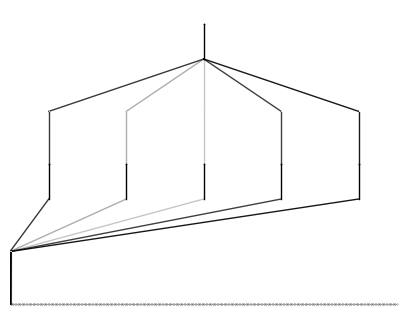

In [74]:
model = model.prune()
model.plot()

continue training

In [76]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

setting lamb=0. If you want to set lamb > 0, set self.save_act=True


| train_loss: 5.16e+17 | test_loss: 3.18e+00 | reg: 0.00e+00 | : 100%|█| 50/50 [01:15<00:00,  1.51s/

saving model version 0.3


In [85]:
model.auto_save

True

predict

In [ ]:
outputs = model(X_test_tensor)

predicted_labels = outputs.argmax(dim=1)

In [ ]:
# Convert tensors to numpy arrays if necessary
predicted_labels_np = predicted_labels.detach().cpu().numpy()
y_test_np = y_test_tensor.detach().cpu().numpy()

acc = accuracy_score(y_test_np, predicted_labels_np)
f1 = f1_score(y_test_np, predicted_labels_np, average="weighted")

print("Test Accuracy:", acc)
print("Test F1 Score:", f1)